In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import graph_tool.all as gt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from functions import *


# Style
sns.set_theme(context='paper', style='white', palette='Set2')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Computation

In [44]:
# Get data
meta = get_meta()
graph_embeddings = load_graph_embeddings()

# Format embeddings
labels = []
embeddings = []
for k, v in graph_embeddings.items():
    labels.append(k)
    embeddings.append(v)
embeddings = np.stack(embeddings, axis=0)

# Perform umap
from umap import UMAP
umap = UMAP(
    n_components=2,
    n_neighbors=60,  # 15
    min_dist=.5,  # .1
    metric='euclidean',
    random_state=42,
).fit_transform(embeddings)

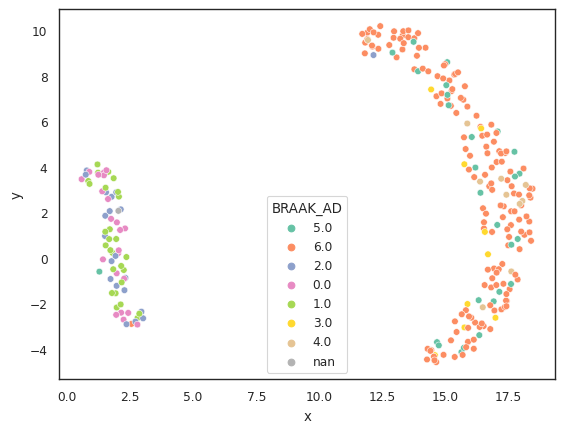

In [50]:
# Get colors
# nps_PsychoAgiCurValue, BRAAK_AD, Sex
col = 'BRAAK_AD'
color_index = np.array([str(v) for v in pd.unique(meta[col])])
color = []
for sid in labels:
    val = str(meta.loc[meta['SubID']==sid][col].item())
    color.append(val)
color = np.array(color)

# Plot
df = pd.DataFrame({
    'x': umap[:, 0],
    'y': umap[:, 1],
    col: color})
sns.scatterplot(data=df, x='x', y='y', hue=col)
plt.savefig('../plots/embeddings.pdf', format='pdf', transparent=True)